This notebook is for creating graphs of the benchmark case study, specifically using datasets where all the data is available.

Currently this notebook resides in the `notebooks` folder, but in order for it to run, it must be moved out to the main folder. 

# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

print(os.getcwd())

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


c:\Users\user\Documents\research\BMCA-pipeline\notebooks\all_data


In [2]:
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/all_data/')

In [3]:
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_yeast.ant' 

data_file3 = '../../data/interim/generated_data/simpliTeusink-noReg/Simplified_Teusink_yeast_3.0.csv'
data_file5 = '../../data/interim/generated_data/simpliTeusink-noReg/Simplified_Teusink_yeast_5.csv'
data_file7 = '../../data/interim/generated_data/simpliTeusink-noReg/Simplified_Teusink_yeast_7.0.csv'
data_file100 = '../../data/interim/generated_data/simpliTeusink-noReg/Simplified_Teusink_yeast_10.csv'

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

# data_files = [data_file05, data_file10, data_file15, data_file3, data_file5, data_file7, data_file100]

1.5710734600032811e-15

In [4]:
BMCA_obj3 = BMCA.BMCA(Teusink_ant, data_file3)

AssertionError: data does not describe steady state

In [19]:
ref_ind=0
model_file=Teusink_ant
data_file = data_file3

# a function, because a method takes in 'self'
"""
this method takes in an SBML model and csv data to establish important
attributes
"""
r = te.loada(model_file)
r.conservedMoietyAnalysis = True

if isinstance(data_file, str):
    df = pd.read_csv(data_file)
elif isinstance(data_file, pd.DataFrame):
    df = data_file

# in case of omitted data
available_fl_sp = [i for i in r.getFloatingSpeciesIds() if i in df.columns]
available_bd_sp = [i for i in r.getBoundarySpeciesIds() if i in df.columns]

enzymes = ['e_' + i for i in r.getReactionIds()]
available_enz = [i for i in enzymes if i in df.columns]

fluxes = ['v_' + i for i in r.getReactionIds()]
available_fluxes = [i for i in fluxes if i in df.columns]

# clean the data
data = df.drop(df[df[available_fl_sp].lt(0).any(axis=1)].index)

# sorting the data

e = data[available_enz]
x = data[available_fl_sp]
y = data[available_bd_sp]
v = data[available_fluxes]

# normalizing the data
#  'ref' should be the first row of data
# ref_ind = data.idxmax()[desired_product]   
e_star = e.iloc[ref_ind].values
x_star = x.iloc[ref_ind].values
y_star = y.iloc[ref_ind].values
v_star = v.iloc[ref_ind].values

e_star[e_star == 0] = 1e-6
x_star[x_star == 0] = 1e-6
y_star[y_star == 0] = 1e-6
v_star[v_star == 0] = 1e-9

# Normalize to reference values (and drop trivial measurement)
en = e.divide(e_star)
xn = x.divide(x_star)
yn = y.divide(y_star)
vn = v.divide(v_star)

#en.drop(en.index[ref_ind], inplace=True)
#xn.drop(xn.index[ref_ind], inplace=True)
#yn.drop(yn.index[ref_ind], inplace=True)
#vn.drop(vn.index[ref_ind], inplace=True)

N = r.getFullStoichiometryMatrix()

filler_v_star = list(v_star).copy()
filler_indices = set(range(len(fluxes))) - set([fluxes.index(i) for i in available_fluxes])
for i in filler_indices:
    filler_v_star.insert(i, 1)
filler_v_star = np.array(filler_v_star)

# Correct negative flux values at the reference state
N[:, filler_v_star < 0] = -1 * N[:, filler_v_star < 0]
v_star = np.abs(v_star)

assert np.all(np.isclose(np.matmul(N, filler_v_star), 0)), "data does not describe steady state"

yn[yn == 0] = 1E-6

xn = np.log(xn)
yn = np.log(yn)

# return N, v_star, en, xn, yn, vn, x_star

In [10]:
np.isclose(np.all(np.matmul(N, filler_v_star)), 0)

False

In [18]:
np.all(np.isclose(np.matmul(N, filler_v_star), 0))

True

In [16]:
np.all(np.matmul(N, filler_v_star))

True

In [81]:
r.getScaledElasticityMatrix()

                 P,        G6P,     TRIO,      NAD,     ACE,    P2G,        BPG,       GLCi,       F6P,       PEP,       PYR,      F16P,      P3G,       NADH
vGLK   [[  1.02118, -0.0165999,        0,        0,       0,      0,          0,   0.457337,         0,         0,         0,         0,        0,          0],
vPGI    [        0,    1.18397,        0,        0,       0,      0,          0,          0, -0.710951,         0,         0,         0,        0,          0],
vGLYCO  [        0,          0,        0,        0,       0,      0,          0,          0,         0,         0,         0,         0,        0,          0],
vTreha  [        0,          0,        0,        0,       0,      0,          0,          0,         0,         0,         0,         0,        0,          0],
vPFK    [ -3.20472,          0,        0,        0,       0,      0,          0,          0,   0.93355,         0,         0, -0.400941,        0,          0],
vALD    [        0,          0, -3.10067, 

In [4]:
BIOMD64 = ogBMCA.BMCA(Teusink_ant, data_file)

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

In [5]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
flux = ['v_' + i for i in r.getReactionIds()]

In [6]:
a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:].tolist() if i.values.size > 0]
pt_enz.insert(0, 'WT')

a = data[data[enzymes] != 1].values.flatten()
# a = data[enzymes].values.flatten()
pt_lvls = a[~np.isnan(a)]
pt_lvls = list(pt_lvls)
pt_lvls.insert(0, 1.0)

# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]

# Leaving out internal species concentrations

In [8]:
N_SPLITS=6
splits = np.linspace(0,1, N_SPLITS+1)[1:]

In [9]:
crossSections=[]

for i in np.random.randint(1000, size=N_SPLITS): 
    kept, omitted = train_test_split(internal, test_size=0.33, random_state=i)
    holey_data = pd.concat([data[kept], data[flux], data[enzymes], data[external]], axis=1)
    crossSections.append(holey_data)


In [10]:
BIOMD64_0 = ogBMCA.BMCA(Teusink_ant, crossSections[0])
#BIOMD64_1 = BMCA.BMCA(Teusink_ant, crossSections[1])
#BIOMD64_2 = BMCA.BMCA(Teusink_ant, crossSections[2])
#BIOMD64_3 = BMCA.BMCA(Teusink_ant, crossSections[3])
#BIOMD64_4 = BMCA.BMCA(Teusink_ant, crossSections[4])
#BIOMD64_5 = BMCA.BMCA(Teusink_ant, crossSections[5])

Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

## Running ADVI

In [11]:
def calculate_Xss(BMCA_obj):
    
    n_exp = len(BMCA_obj.en)

    product = (BMCA_obj.en*BMCA_obj.v_star)
    N_rep = BMCA_obj.N.reshape((-1, *BMCA_obj.N.shape)).repeat(n_exp, axis=0) # (642, 14, 17)

    def my_func(a): 
        return np.diag(a)
    c = np.apply_along_axis(my_func, 1, product)

    Ex_rep = BMCA_obj.Ex.values.reshape((-1, *BMCA_obj.Ex.shape)).repeat(n_exp, axis=0) # (642, 14, 17)

    As = (N_rep@c@Ex_rep) # (43, 16, 16)

    arr = ((np.ones((len(BMCA_obj.N.T),n_exp)) + (BMCA_obj.Ey @ BMCA_obj.yn.T))).values
    arr = arr.T[:,:, np.newaxis]
    bs = -(N_rep@c) @ arr # (642, 14, 642)

    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()
    
    xn, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)
    
    vn = BMCA_obj.en.values * (np.ones((len(BMCA_obj.v_star), n_exp)) +
                   at.dot(BMCA_obj.Ex, BMCA_obj.xn.T) +
                   at.dot(BMCA_obj.Ey, BMCA_obj.yn.T)).T

    return xn, vn

In [13]:
def run_BayesInf(BMCA_obj):
    known_chi_inds = []
    omitted_chi_inds = []
    for i, sp in enumerate(r.getFloatingSpeciesIds()):
        if sp in holey_data.columns:
            known_chi_inds.append(i)
        else: 
            omitted_chi_inds.append(i)
    chi_inds = np.hstack([known_chi_inds, omitted_chi_inds]).argsort()
    
    with pm.Model() as pymc_model:
    
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))

        # trace_prior = pm.sample_prior_predictive(samples=1000)
        
        chi_measured = pm.Normal('chi_measured', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        chi_unmeasured = pm.Normal('chi_unmeasured', mu=0, sigma=10, shape=(len(omitted_chi_inds), len(BMCA_obj.xn)))

        chi_t = at.concatenate([chi_measured, chi_unmeasured], axis=0)[chi_inds, :]
        # supposedly chi_t would be in the order listed in ss tellurium

        pm.Deterministic('chi_t', chi_t)

        e_t = pm.Normal('e_t', mu=1, sigma=1, observed=BMCA_obj.en.T) # e_hat?
        y_t = pm.Normal('y_t', mu=0, sigma=10, observed=BMCA_obj.yn.T) # yn?

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)

        N_ITERATIONS = 40000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 40,011


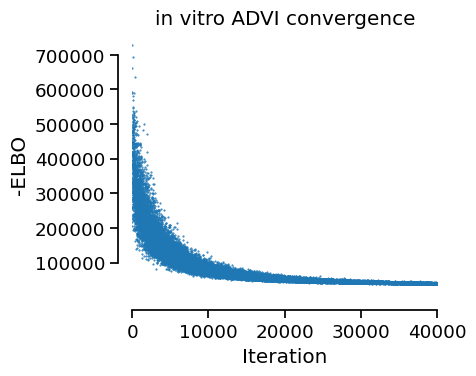

In [14]:
trace_0 = run_BayesInf(BIOMD64_0)
#trace_1 = run_BayesInf(BIOMD64_1)
#trace_2 = run_BayesInf(BIOMD64_2)
#trace_3 = run_BayesInf(BIOMD64_3)
#trace_4 = run_BayesInf(BIOMD64_4)
#trace_5 = run_BayesInf(BIOMD64_5)


### Plotting ADVI results

In [27]:
Ex_0 = (trace_0['posterior']['Ex']).to_numpy().squeeze()# .transpose(1, 2, 0)

## Plotting MCC and FCC comparisons

Let's plot posterior FCC distribution, just for ethanol, because supposedly we only care about the terminal yield

In [28]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return CCC.eval(), FCC


In [29]:
BMCA_obj = BIOMD64_0
postCCC, postFCC = estimate_CCs(BMCA_obj, Ex_0)

In [30]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

(-5.0, 5.0)

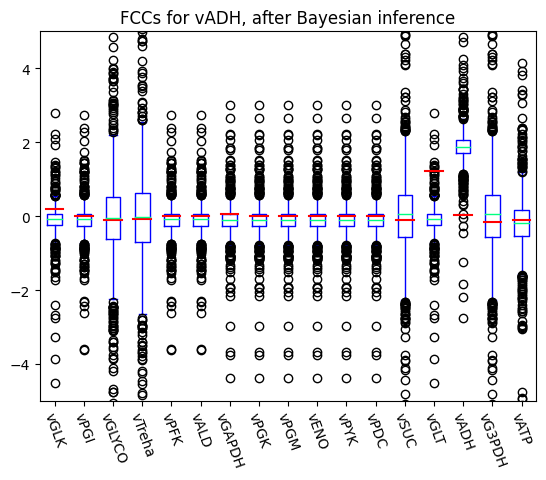

In [38]:
ADH_idx = r.getReactionIds().index('vADH')
ADH_FCCs = pd.DataFrame(postFCC[:,:, ADH_idx], columns=r.getReactionIds())

ADH_FCCs.plot(kind='box', colormap='winter')
plt.title('FCCs for vADH, after Bayesian inference')

for i,val in enumerate(gtFCC.loc['vADH']): # .sort_index()
    plt.axhline(y = val,    # Line on y = 0.2
            xmin = (i+0.2)/len(gtFCC['vADH']), # From the left
            xmax = (i+0.8)/len(gtFCC['vADH']), 
            c='red') # To the right
    
plt.xticks(rotation=-70)
plt.ylim((-5,5))

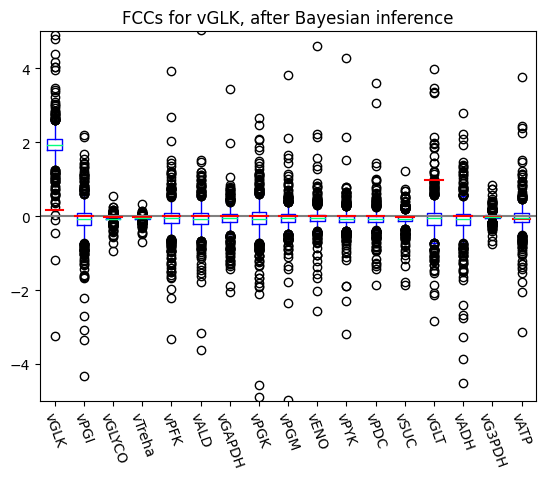

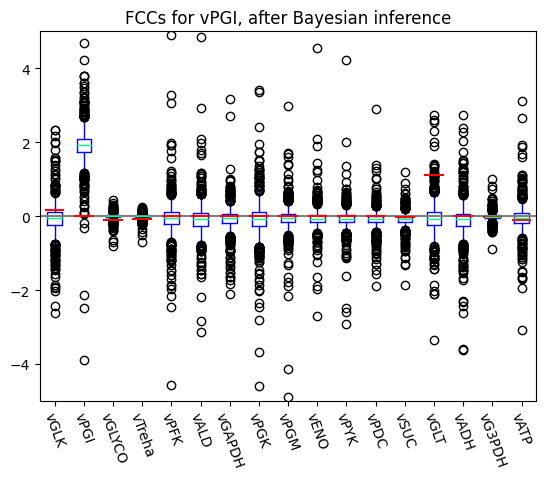

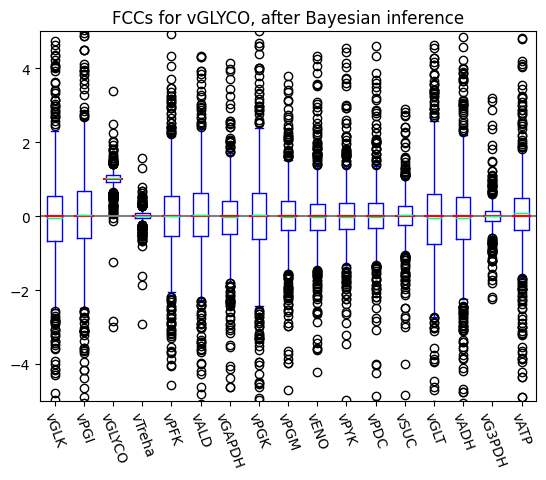

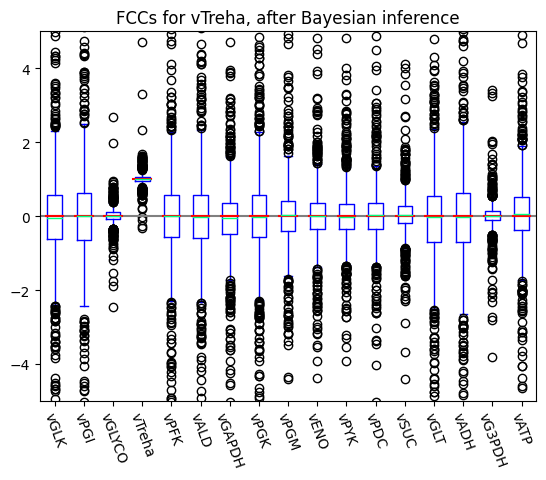

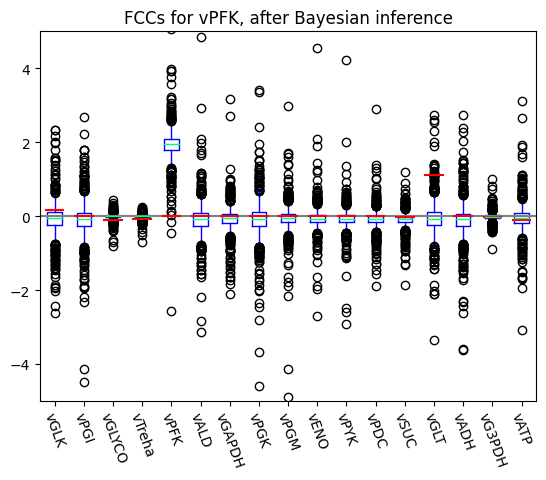

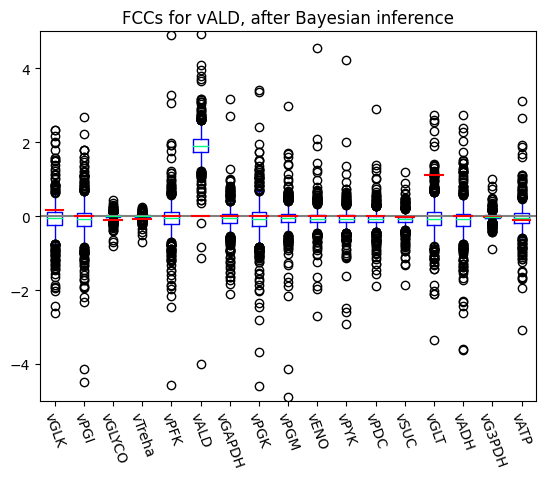

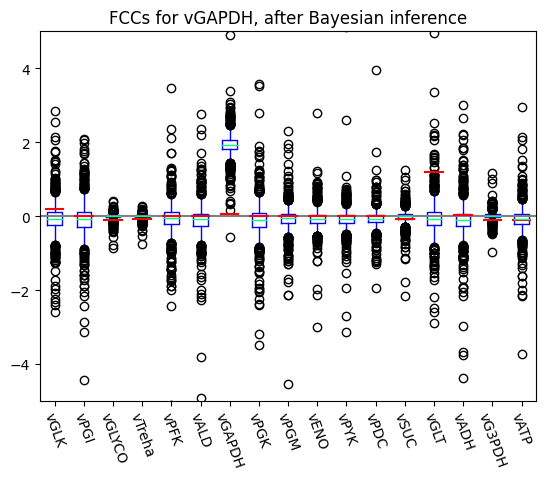

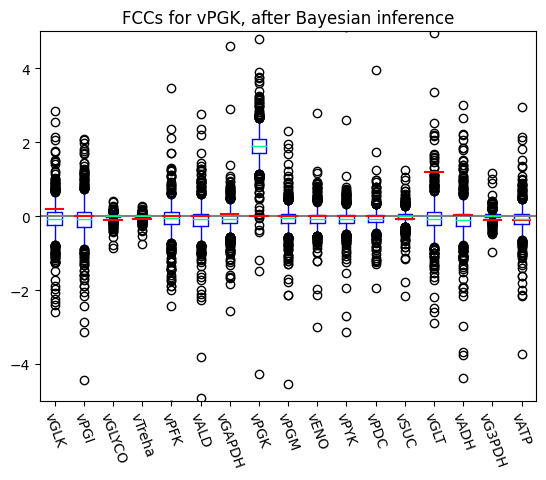

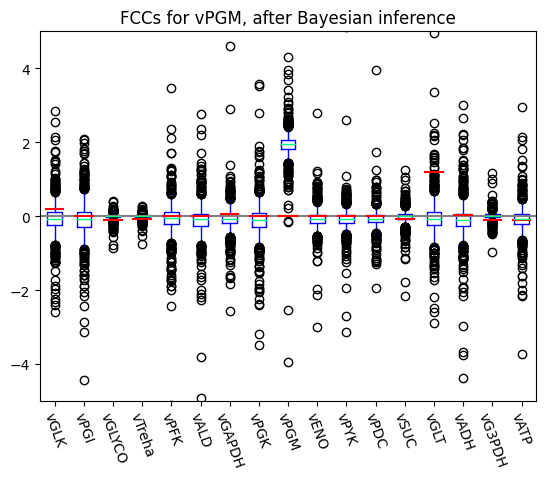

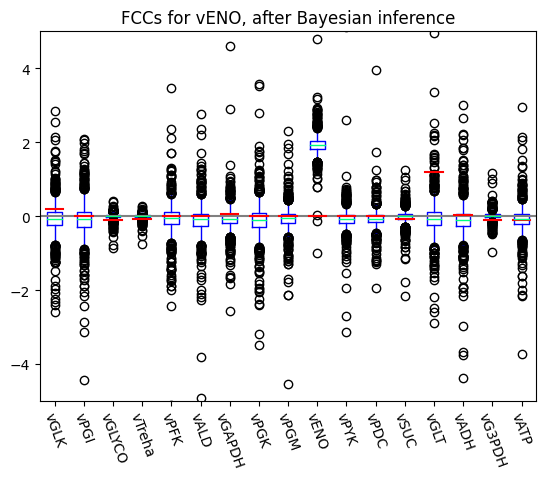

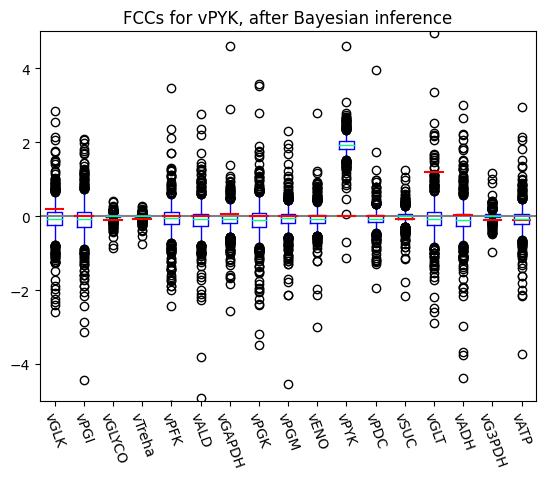

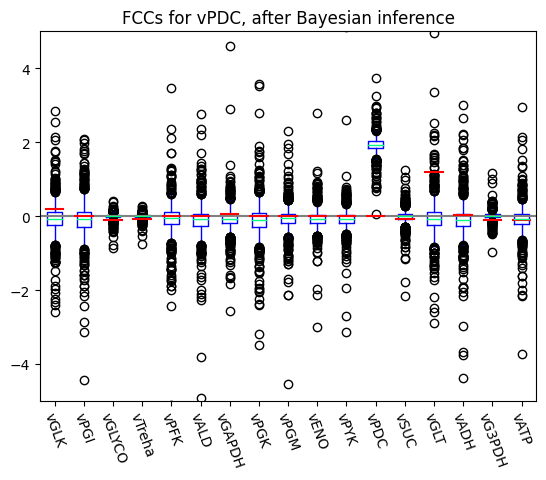

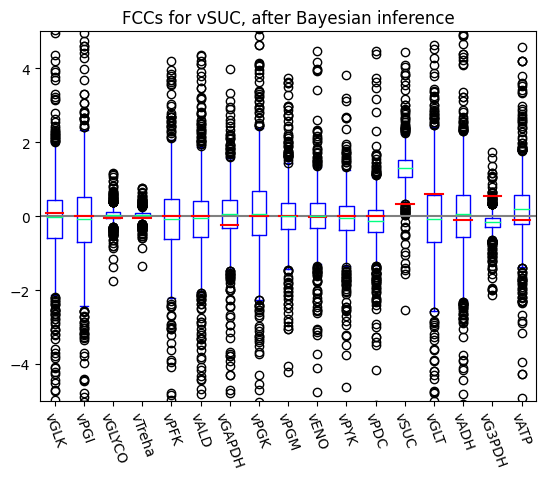

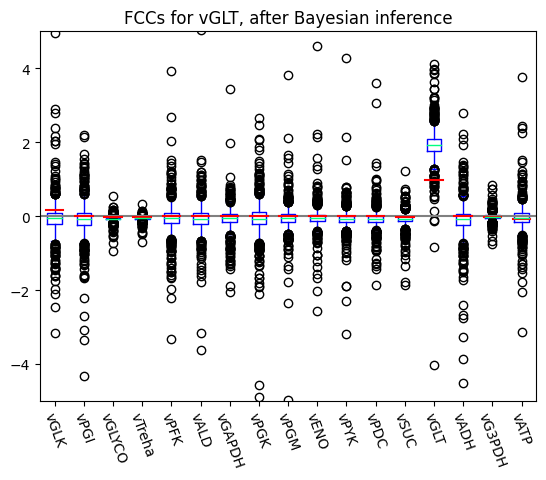

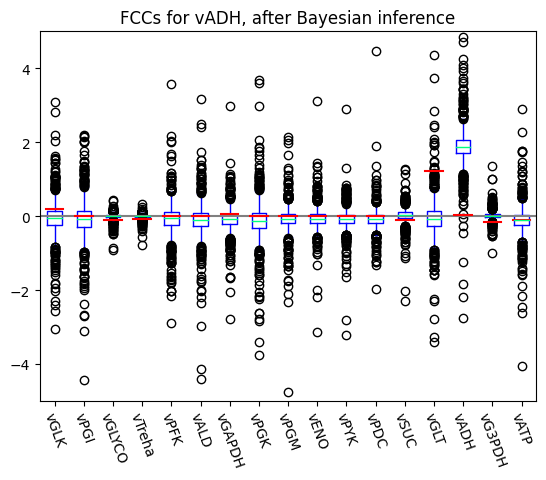

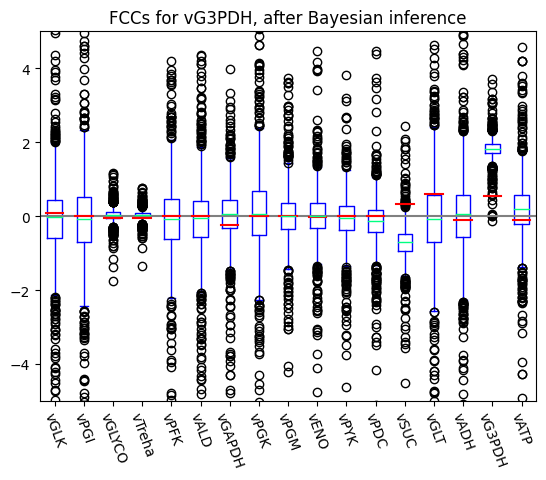

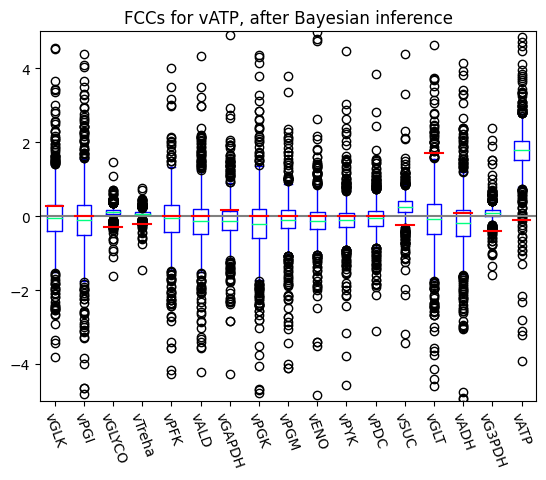

In [71]:
for b, rxn in enumerate(r.getReactionIds()): 
    ADH_FCCs = pd.DataFrame(postFCC[:,b, :], columns=r.getReactionIds())

    ADH_FCCs.plot(kind='box', colormap='winter')
    plt.axhline(0, c='gray')
    plt.title(f'FCCs for {rxn}, after Bayesian inference')

    for i,val in enumerate(gtFCC.loc[r.getReactionIds()[b]]): # .sort_index()
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC['vADH']), # From the left
                xmax = (i+0.8)/len(gtFCC['vADH']), 
                c='red') # To the right
        
    plt.xticks(rotation=-70)
    plt.ylim((-5,5))
   

In [49]:
vPFK
vALD
vGAPDH
vPGK

14

In [34]:
gtFCC

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH,vATP
vGLK,0.155598,0.002182,-0.021337,-0.014715,0.001661,0.000351,0.013258,0.000378,0.000309,0.000840,0.000429,0.000256,-0.017896,0.984936,0.005601,-0.028930,-0.082920
vPGI,0.177323,0.002486,-0.101886,-0.078826,0.001893,0.000400,0.015109,0.000431,0.000352,0.000958,0.000488,0.000292,-0.020395,1.122458,0.006383,-0.032969,-0.094498
vGLYCO,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vTreha,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vPFK,0.177323,0.002486,-0.101886,-0.078826,0.001893,0.000400,0.015109,0.000431,0.000352,0.000958,0.000488,0.000292,-0.020395,1.122458,0.006383,-0.032969,-0.094498
vALD,0.177323,0.002486,-0.101886,-0.078826,0.001893,0.000400,0.015109,0.000431,0.000352,0.000958,0.000488,0.000292,-0.020395,1.122458,0.006383,-0.032969,-0.094498
vGAPDH,0.188586,0.002644,-0.107526,-0.083334,0.002014,0.000426,0.047613,0.001357,0.001108,0.003018,0.001539,0.000921,-0.068156,1.193754,0.021329,-0.110646,-0.094647
vPGK,0.188586,0.002644,-0.107526,-0.083334,0.002014,0.000426,0.047613,0.001357,0.001108,0.003018,0.001539,0.000921,-0.068156,1.193754,0.021329,-0.110646,-0.094647
vPGM,0.188586,0.002644,-0.107526,-0.083334,0.002014,0.000426,0.047613,0.001357,0.001108,0.003018,0.001539,0.000921,-0.068156,1.193754,0.021329,-0.110646,-0.094647
vENO,0.188586,0.002644,-0.107526,-0.083334,0.002014,0.000426,0.047613,0.001357,0.001108,0.003018,0.001539,0.000921,-0.068156,1.193754,0.021329,-0.110646,-0.094647


In [206]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())
r.getScaledFluxControlCoefficientMatrix()

               vGLK,        vPGI,     vGLYCO,     vTreha,         vPFK,         vALD,    vGAPDH,        vPGK,        vPGM,        vENO,        vPYK,        vPDC,       vSUC,     vGLT,       vADH,     vG3PDH,       vATP, vAK
vGLK   [[  0.152353, 0.000452762, -0.0229202, -0.0158812,  -0.00124511, -0.000368311, 0.0114753,  0.00033111,  0.00027181, 0.000743455, 0.000382412, 0.000232878, -0.0186981,  1.00455, 0.00587082, -0.0305939,  -0.086954,   0],
vPGI    [  0.173547, 0.000515747,  -0.103393, -0.0799182,  -0.00141832, -0.000419547, 0.0130716, 0.000377172, 0.000309622, 0.000846879,  0.00043561, 0.000265275, -0.0212992,  1.14429, 0.00668752, -0.0348499, -0.0990503,   0],
vGLYCO  [         0,           0,          1,          0,            0,            0,         0,           0,           0,           0,           0,           0,          0,        0,          0,          0,          0,   0],
vTreha  [         0,           0,          0,          1,            0,            0,         0,  

In [201]:
for i,val in enumerate(gtFCC['vADH']):
    print(val)

0.005870816501742502
0.0066875206232999375
0.0
0.0
0.006687520623300485
0.006687520623300308
0.021664714249089223
0.021664714249090136
0.021664714249089022
0.021664714249089178
0.021664714249089143
0.021664714249089247
-0.10584801409935828
0.0058708165017425
0.02883460102190083
-0.10584801409935828
0.07580121458504183
-1.9004522009670584


In [22]:
def plot_pairwise_FCCs(yield_enzyme):
    fig = plt.figure() 
    for i, BIOMD64 in enumerate(all_BIOMD64):
        
        """visCCC, visFCC = util.elasticity_to_CCC(BIOMD64, BIOMD64.Ex)  
        visCCC = pd.DataFrame(visCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
        visFCC.columns = r.getReactionIds()
        visFCC.index = r.getReactionIds()"""

        postCCC, postFCC = util.elasticity_to_CCC(BIOMD64, all_Exs[i])  
        postCCC = pd.DataFrame(postCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
        postFCC = pd.DataFrame(postFCC) #, index=r.getReactionIds(), columns=r.getReactionIds())
        postFCC.columns = r.getReactionIds()
        postFCC.index = r.getReactionIds()

        #priors = pd.DataFrame(visFCC[yield_enzyme])
        #priors['distribution'] = ['prior']* len(priors)
        posteriors = pd.DataFrame(postFCC[yield_enzyme])
        posteriors['distribution'] = ['posterior']* len(posteriors)
        paired = posteriors.reset_index() # pd.concat([priors, posteriors]).reset_index()
        pv_tbl = paired.pivot('index', 'distribution', yield_enzyme)

        pv_tbl[['prior', 'posterior']].plot(kind='bar', colormap='winter')
    plt.title(f'FCCs for {yield_enzyme}, before & after Bayesian inference')

    for i,val in enumerate(gtFCC[yield_enzyme].sort_index()):
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[yield_enzyme]), # From the left
                xmax = (i+0.8)/len(gtFCC[yield_enzyme]), 
                c='red') # To the right

In [ ]:
for i,rxn in enumerate(r.getReactionIds()):
    plot_pairwise_FCCs(rxn)

In [ ]:
fig = plt.figure()

plt.scatter(gtCCC, visCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.ylim([-5,5])
plt.title('Comparing scaled concentration control coefficients, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), visCCC.to_numpy().flatten())[0]).round(3)))


In [ ]:
fig = plt.figure()

plt.scatter(gtCCC, postCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled concentration control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), postCCC.to_numpy().flatten())[0]).round(3)))

In [ ]:
fig = plt.figure()

plt.scatter(gtFCC, visFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')
plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), visFCC.to_numpy().flatten())[0]).round(3)))

In [ ]:
fig = plt.figure()

plt.scatter(gtFCC, postFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), postFCC.to_numpy().flatten())[0]).round(3)))

In [ ]:
FCCrankings = pd.concat([gtFCC.loc['vADH'].rank(), visFCC.loc['vADH'].rank(), postFCC.loc['vADH'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings, vADH')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))
plt.legend()

In [ ]:
FCCrankings = pd.concat([gtFCC.loc['vGLK'].rank(), visFCC.loc['vGLK'].rank(), postFCC.loc['vGLK'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings,vGLK')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))

plt.legend()

In [ ]:
FCCrankings = pd.concat([gtFCC.loc['vPGI'].rank(), visFCC.loc['vPGI'].rank(), postFCC.loc['vPGI'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings, vPGI')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))

plt.legend()

## Pairwise comparison of FCC values

In [ ]:
def plot_pairwise_FCCs(yield_enzyme):
    priors = pd.DataFrame(visFCC[yield_enzyme])
    priors['distribution'] = ['prior']* len(priors)
    posteriors = pd.DataFrame(postFCC[yield_enzyme])
    posteriors['distribution'] = ['posterior']* len(posteriors)
    paired = pd.concat([priors, posteriors]).reset_index()
    pv_tbl = paired.pivot('index', 'distribution', yield_enzyme)

    fig = pv_tbl[['prior', 'posterior']].plot(kind='bar', colormap='winter')
    plt.title(f'FCCs for {yield_enzyme}, before & after Bayesian inference')

    for i,val in enumerate(gtFCC[yield_enzyme].sort_index()):
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[yield_enzyme]), # From the left
                xmax = (i+0.8)/len(gtFCC[yield_enzyme]), 
                c='red') # To the right

In [ ]:
for i,rxn in enumerate(r.getReactionIds()):
    plot_pairwise_FCCs(rxn)

## Distribution of FCC Sp. correlation coefficients

In [ ]:
visE_r=[]
postE_r=[]

for i in r.getReactionIds():        
    FCCrankings = pd.concat([gtFCC.loc[i].rank(), visFCC.loc[i].rank(), postFCC.loc[i].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    visE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0])
    postE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0])


In [ ]:
plt.hist(visE_r, label='priors')
plt.hist(postE_r, alpha=0.7, label='posteriors')
plt.legend()
plt.xlabel('Spearman corr. coefficient value')
plt.ylabel('frequency')
plt.title('Spread of Spearman corr. coefficients for FCCs of glyscolysis reactions')

plt.show()


# Perturbing enzymes, leaving out flux values 

In [ ]:
kept, omitted = train_test_split(internal, test_size=0.33, random_state=42)

In [ ]:
holey_data = pd.concat([data[kept], data[flux], data[enzymes], data[external]], axis=1)
holey_data.head()

In [ ]:
holey_data = pd.concat([data[kept], data[flux], data[enzymes], data[external]], axis=1)
holey_data.head()

In [ ]:
known_flux_inds = []
omitted_flux_inds = []
for i, v_ in enumerate(flux):
    if v_ in holey_data.columns:
        known_flux_inds.append(i)
    else: 
        omitted_flux_inds.append(i)
flux_inds = np.hstack([known_flux_inds, omitted_flux_inds]).argsort()


## Running ADVI

In [ ]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

In [ ]:
with pymc_model:
    
    e_t = pm.Normal('e_t', mu=1, sigma=1, observed=BIOMD64.en.T)
    chi_t = pm.Normal('chi_t', mu=0, sigma=10, observed=BIOMD64.xn.T)
    y_t = pm.Normal('y_t', mu=0, sigma=10, observed=BIOMD64.yn.T)


In [ ]:
with pymc_model:
    likelihood = pm.Deterministic('vn', e_t * (np.ones((17,641)) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
    
    flux_measured = pm.Normal('flux_measured', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)
    flux_unmeasured = pm.Normal('flux_unmeasured', mu=likelihood, sigma=10, shape=(len(omitted_chi_inds), len(BIOMD64.xn)))

    v_t = at.concatenate([flux_measured, flux_unmeasured], axis=0)[flux_inds, :]
    # supposedly chi_t would be in the order listed in ss tellurium

    pm.Deterministic('v_t', v_t)

In [ ]:
v_t.shape.eval() # 14, 641

In [ ]:
likelihood.shape.eval() # 14, 641
